# Unsolved Homicides

## The Plan
### Scrape data from OH-AG website
- [x] Don't break their website
- [x] Create dataframe of cases
### Basic stats
- Bar graph of cases?
- oldest case
- avg / median age of case
    - distribution plot + highlight median value
- avg / median age of victim
- oldest / youngest victims
- pie chart of ethnicity
- Age of case vs Agency
### GIS
- Map cases
    - Different symbol for different gender
    - Decreasing color value for 0-4, 5-9, 1-14, +15 year old cases
- Heat map by neighborhood
    - by street / block
- Time of day vs location
## Other
 - [x] Manually extract age from ['details']
     - [ ] Manually extract homicide method? eg; knife, gun? There's ~500 entries....
     - surprising / depressing number of infant homicides & entire families
 - [ ] Histogram
     - [x] by Age
     - [ ] Time since incident
     - [x] Month
     - [x] Sex
 - [ ] Correlogram ?
 - [ ] Summary statistics
 - I'll probably have to clean up the ['Incident location'] data in order to use it in mapping. I *should* be able to automate it
     - [ ] clean location data ?
 ## links
 
- https://www.murderdata.org
- https://projectcoldcase.org

In [611]:
                                                         # jupyter v1.0.0
import pandas as pd                                      # v1.4.3
import numpy as np
import geopandas as gpd  # will I use this?                v0.8.2
from matplotlib import pyplot as plt                     # v3.5.2
from bokeh.io import output_notebook, show
from bokeh import plotting
import folium                                            # v0.12.1.post1
output_notebook()
'''
isa_colors = ['yellow' = '#FCF434'
'dark yellow' = '#e4de49'
'lavender' = '#cc94f8'
'purple' = '#9C59D1'
'dark purple' = '#401066'
'charcoal' = '#7e7c7c'
'black' = '#2C2C2C'
'light pink'= '#e58cba'
'pink' = '#D60270'
'periwinkle' = '#99b9fa'
'blue' = '#0038A8'
'''

Loading BokehJS ...

"\nisa_colors = ['yellow' = '#FCF434'\n'dark yellow' = '#e4de49'\n'lavender' = '#cc94f8'\n'purple' = '#9C59D1'\n'dark purple' = '#401066'\n'charcoal' = '#7e7c7c'\n'black' = '#2C2C2C'\n'light pink'= '#e58cba'\n'pink' = '#D60270'\n'periwinkle' = '#99b9fa'\n'blue' = '#0038A8'\n"

In [612]:
cases = pd.read_csv('unsolved_OH.csv')
case_df = cases.T.copy()
case_df.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Unnamed: 0,Case number,Incident location,Incident date,Homicide date,Gender,Race/Ethnicity,Law enforcement agency,details,Age,Hair color,Eye color,Nickname or alias,Date of birth,Height,Weight
618,618,"3540 Reading RoadCincinnati, \n ...",1/2/2011,1/2/2011,Male,Black,Cincinnati Police Department,Twenty two year old Rafeal Ross was shot at 3...,22,NaN,NaN,NaN,NaN,NaN,NaN
632,632,"5438 Madison RoadCincinnati, \n ...",5/26/2011,5/26/2011,Male,Black,Cincinnati Police Department,Nineteen year old David Gould was shot at 438...,19,NaN,NaN,NaN,NaN,NaN,NaN
622,622,"201 Peete StreetCincinnati, \n ...",3/1/2011,3/1/2011,Male,Black,Cincinnati Police Department,Twenty five year old Patrick Massey was shot ...,25,NaN,NaN,NaN,NaN,NaN,NaN


## Exploring the Data
- [x] Transpose to more standard format
- [x] Check data types
    - [x] Clean up ['Incident date'] 
        - [x] Isolate date ranges
        - [x] Date ranges truncated to initial date
        - [x] Convert date ranges to datetime object
        - [x] Convert ['Incident date'] to datetime object
        - [x] Update ['Incident date'] to complete dates for maximum number of cases
- [x] Handle empty values
    - dropped

In [3]:
case_df.shape

(478, 15)

In [3]:
case_df.dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
dtype: object

In [613]:
case_df.columns = case_df.iloc[0]
case_df = case_df.drop(case_df.index[0], axis=0)
case_df.head()

Unnamed: 0,Case number,Incident location,Incident date,Homicide date,Gender,Race/Ethnicity,Law enforcement agency,details,Age,Hair color,Eye color,Nickname or alias,Date of birth,Height,Weight
618,618,"3540 Reading RoadCincinnati, \n ...",1/2/2011,1/2/2011,Male,Black,Cincinnati Police Department,Twenty two year old Rafeal Ross was shot at 3...,22,NaN,NaN,NaN,NaN,NaN,NaN
632,632,"5438 Madison RoadCincinnati, \n ...",5/26/2011,5/26/2011,Male,Black,Cincinnati Police Department,Nineteen year old David Gould was shot at 438...,19,NaN,NaN,NaN,NaN,NaN,NaN
622,622,"201 Peete StreetCincinnati, \n ...",3/1/2011,3/1/2011,Male,Black,Cincinnati Police Department,Twenty five year old Patrick Massey was shot ...,25,NaN,NaN,NaN,NaN,NaN,NaN
635,635,"23 Back StreetCincinnati, \n O...",6/26/2011,6/26/2011,Male,Black,Cincinnati Police Department,Eighteen year old Dion Thomas was shot at 23 ...,18,NaN,NaN,NaN,NaN,NaN,NaN
637,637,"1891 Biegler StreetCincinnati, \n ...",7/22/2011,7/22/2011,Male,Black,Cincinnati Police Department,Forty five year old Roger Holmes was shot at ...,45,NaN,NaN,NaN,NaN,NaN,NaN


In [614]:
# Age needs to be float because of infants.
case_df = case_df.astype({'Case number':int, 'Age': 'float32'}, copy=True)

In [6]:
case_df.dtypes

Unnamed: 0
Case number                 int32
Incident location          object
Incident date              object
Homicide date              object
Gender                     object
Race/Ethnicity             object
Law enforcement agency     object
details                    object
Age                       float32
Hair color                 object
Eye color                  object
Nickname or alias          object
Date of birth              object
Height                     object
Weight                     object
dtype: object

In [615]:
# Replace ranges of ['Incident date']s with initial date
date_error_df =  pd.to_datetime(case_df['Incident date'], errors='coerce')
nat_df = date_error_df[date_error_df.isna()==True]

In [616]:
nat_cases = list(nat_df.index.astype(int))
nat_cases

[1008,
 842,
 676,
 650,
 688,
 689,
 829,
 690,
 751,
 3142,
 850,
 3216,
 66,
 287,
 288,
 289]

In [617]:
# data frame of cases that have Not a date Time values
nat_case_df = case_df[case_df['Case number'].isin(nat_cases)].copy()
#6/21/2008 - 8/7/2009 (Approximate) 	
nat_column = nat_case_df['Incident date'].str.split(pat='-', expand=True)
# drop '- | 8/7/2009' columns
nat_column.drop(labels=1, axis=1, inplace=True)
nat_column.rename(columns={0:'Incident date'}, inplace=True)

In [618]:
nat_column['Case number'] = nat_column.index
nat_column.head()

,Incident date,Case number
1008,6/21/2008,1008
842,5/26/1998,842
676,Unknown,676
650,Unknown,650
688,10/22/1969,688


In [619]:
incident_date_dt = pd.DataFrame(pd.to_datetime(nat_column['Incident date'], yearfirst=True, errors='coerce'))
incident_date_dt['Incident date'] = incident_date_dt['Incident date'].astype('<M8[ns]')
incident_date_dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 1008 to 289
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Incident date  14 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 256.0+ bytes


In [620]:
incident_date_dt.loc['688']['Incident date'].dtype()

AttributeError: 'Timestamp' object has no attribute 'dtype'

## Changed case_df to case_df1 <<<< change back once fixed

In [81]:
''' for troubleshooting
case_df1 = case_df.copy()
case_df1['Incident date'].astype('datetime64[ns]')
'''

In [621]:
# don't try to use format=' ' this data breaks it and everything turns into NaTs
# https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
case_df['Incident date'] = pd.to_datetime(case_df['Incident date'], errors='coerce')
case_df['Incident date'] = case_df1['Incident date'].astype('datetime64[ns]')

In [622]:
case_df['Incident date']

618    2011-01-02
632    2011-05-26
622    2011-03-01
635    2011-06-26
637    2011-07-22
          ...    
287    1966-09-25
288    1966-09-25
289    1966-09-25
290    2010-06-11
3148   2005-02-15
Name: Incident date, Length: 477, dtype: datetime64[ns]

In [623]:
# np.float32 / np.datetime64[ns] dtype fighting I don't understand why they're converted differently. 
# is one of these actually a series instead of a df? grr.
# This worked but it raised errors. Finding a fix is taking too much time.
case_df.update(incident_date_dt, overwrite=False)
case_df.info

TypeError: The DTypes <class 'numpy.dtype[datetime64]'> and <class 'numpy.dtype[float32]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In [624]:
case_df.loc['288']['Incident date']

Timestamp('1966-09-25 00:00:00')

In [625]:
case_df[case_df['Incident date'].isna()==True]

Unnamed: 0,Case number,Incident location,Incident date,Homicide date,Gender,Race/Ethnicity,Law enforcement agency,details,Age,Hair color,Eye color,Nickname or alias,Date of birth,Height,Weight
676,676,"Cincinnati, \n Ohio\n ...",NaT,Unknown,Female,None,Cincinnati Police Department,Date of of death 1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
650,650,"2201 Harrison AvenueCincinnati, \n ...",NaT,11/15/2011,Male,None,Cincinnati Police Department,Twenty four year old Muhammad Mumin was shot ...,24.0,NaN,NaN,NaN,NaN,NaN,NaN


In [626]:
case_df['Incident date'] = case_df['Incident date'].astype('datetime64[ns]')

In [627]:
case_df['Incident date'].dtypes

dtype('<M8[ns]')

In [ ]:
case_df.dtypes

In [ ]:
case_df.info()

## Visualization
- [x] Age distribution 10 year bins?
- [ ] By street? 
- [x] By Agency
    - Uninteresting data. Skip
- [x] By Incident date, decade?

In [628]:
a = case_df.sort_values(by=['Age']).Age

In [629]:
age_count = a.value_counts(ascending=False, dropna=False).to_frame()
age_count.rename(columns={'Age':'count'}, inplace=True)
age_count['Age'] = age_count.index.astype('str')
# ages = pd.unique(a).astype('str')

In [630]:
age_count.sort_values(by='Age', inplace=True)

In [112]:
'''
bar = plotting.figure(x_range=age_count['Age'], title='Victim Age Distribution', tools="wheel_zoom,reset,pan")
bar.vbar(x=age_count['Age'], top=age_count['count'])
show(bar)
'''

In [631]:
ages = [0, 10, 20, 30, 40, 50, 70, 110] 
# age_bins = pd.cut(ab['Age'], bins=ages, labels=['0-10', '10-20', '20-30', '30-40', '40-50', '+50'])
case_bin = case_df.groupby(["Gender", pd.cut(case_df['Age'], bins=ages)], dropna=True)
binned_cases = case_bin.size().unstack()

In [632]:
binned_cases

Age,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 70]","(70, 110]"
Gender,,,,,,,
Female,2,5,18,14,13,11,7
Male,4,57,169,57,41,42,15


<AxesSubplot:xlabel='Gender'>

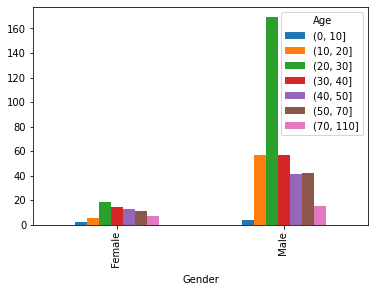

In [633]:
binned_cases.plot(kind="bar", legend=True)

<AxesSubplot:xlabel='Gender'>

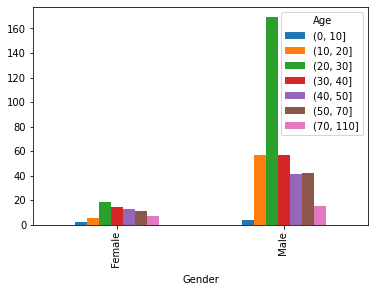

In [116]:
binned_cases.plot.bar(legend=True)

In [634]:
# add column with age bins
case_df['age_bin'] = pd.cut(case_df['Age'], bins=ages)

In [635]:
age_bin = pd.cut(case_df['Age'], bins=ages)

In [636]:
binned = pd.crosstab(age_bin,case_df['Gender'])
binned

Gender,Female,Male
Age,,
"(0, 10]",2,4
"(10, 20]",5,57
"(20, 30]",18,169
"(30, 40]",14,57
"(40, 50]",13,41
"(50, 70]",11,42
"(70, 110]",7,15


In [637]:
a = ['0-10', '11-20','21-30', '31-40', '41-50', '51-70', '+71']
binned['Age'] =a
binned.set_index('Age', inplace=True)
binned

Gender,Female,Male
Age,,
0-10,2,4
11-20,5,57
21-30,18,169
31-40,14,57
41-50,13,41
51-70,11,42
+71,7,15


In [638]:
binned.index

Index(['0-10', '11-20', '21-30', '31-40', '41-50', '51-70', '+71'], dtype='object', name='Age')

In [126]:
'''
age_bar = plotting.figure(x_range=a, title='Victim Age Distribution', tools="wheel_zoom,reset,pan")
colors = ['#0038A8', '#e58cba']
# each category needs an x axis range
age_bar.vbar_stack([' Male', ' Female'], x=['Age', 'Age'], width=0.9, source=binned, color=colors)
show(age_bar)
'''

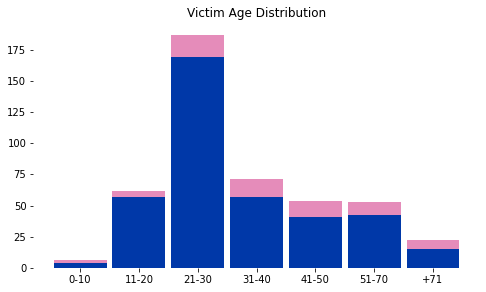

In [350]:
colors = ['#0038A8', '#e58cba'] #blue, pink
fig,ax = plt.subplots(figsize=(8, 4.5))
ax.bar(a, binned[' Male'], width=0.9, color=colors[0])
ax.bar(a, binned[' Female'], bottom=binned[' Male'], width=0.9, color=colors[1])
ax.set_title('Victim Age Distribution')
plt.xticks(range(7), a)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

In [ ]:
binned[' Male'].sum() / (binned[' Male'].sum() + binned[' Female'].sum())

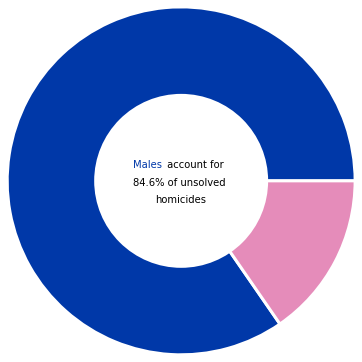

In [358]:
plt.pie([binned[' Male'].sum(), binned[' Female'].sum()], colors=colors ,wedgeprops={'linewidth': 3, 'edgecolor': 'white' },
       pctdistance=0.2, radius=2) 
donut = plt.Circle((0,0), 1, fc='white')
plt.annotate('Males', (-0.55,0.15), color=colors[0])
plt.annotate(' account for', (-0.2,0.15))
plt.annotate('84.6% of unsolved', (-0.55,-0.05))
plt.annotate('homicides', (-0.3,-0.25))
fig = plt.gcf()
fig.gca().add_artist(donut)
plt.show()

In [357]:
pd.value_counts(case_df['Law enforcement agency'])

 Cincinnati Police Department                                            459
 Cincinnati Police Department / Ohio Bureau of Criminal Investigation      4
 Hamilton County Sheriff's Office                                          4
 North College Hill Police Department                                      2
 West Chester Police Department                                            1
 Hamilton County Coroner's Office                                          1
 Butler County Sheriff's Office                                            1
 Grove City Division of Police                                             1
 Loveland Police Department / Ohio Bureau of Criminal Investigation        1
 City of Oxford, Division of Police                                        1
 St. Bernard Police Department                                             1
Name: Law enforcement agency, dtype: int64

In [ ]:
case_df['Incident date'].describe()

In [361]:
years_series = pd.value_counts(case_df['Incident date'].dt.year)
years_df = pd.DataFrame({'Year': years_series.index, 'Homicide Count': years_series.values})
years_df['Year'] = years_df['Year'].astype('int')
years_df.head()

AttributeError: Can only use .dt accessor with datetimelike values

In [140]:
years_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Year            54 non-null     int32
 1   Homicide Count  54 non-null     int64
dtypes: int32(1), int64(1)
memory usage: 776.0 bytes


In [141]:
'''
years = [x for x in range(1950, 2023)]
date_bar = plotting.figure(x_range=(1950,2023), title='Homicides by Year', tools="wheel_zoom,reset,pan")
# each category needs an x axis range
date_bar.vbar(top=years_df['Homicide Count'], x=years_df['Year'], width=0.9)
show(date_bar)
'''

In [368]:
years_df.loc[years_df['Homicide Count'].idxmax()]

Year              2011
Homicide Count      28
Name: 0, dtype: int64

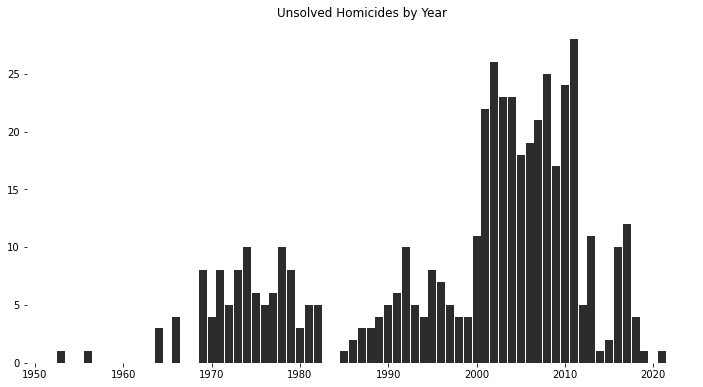

In [501]:
fig, ax = plt.subplots(figsize=(12,6.25))
ax.bar(years_df['Year'], years_df['Homicide Count'], width=0.9, color='#2C2C2C')
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax.set_title('Unsolved Homicides by Year')
plt.show()

- What happened in:
    - 1984-1988
    - 1999 - 2011
    - what years were DOJ oversight program?
    - Get Homicide data for same period?
    - Why 2011 28 unsolved cases. What happened in 2011

In [142]:
months_series = pd.value_counts(case_df['Incident date'].dt.month)
months_df = pd.DataFrame({'Month': months_series.index, 'Homicide Count':months_series.values})
months_df.sort_values('Homicide Count', ascending=False, inplace=True)
months_df['Month'] = months_df['Month'].astype(int)
months_df

,Month,Homicide Count
0,3,56
1,10,48
2,11,44
3,4,43
4,6,38
5,12,38
6,8,38
7,7,36
8,5,34
9,2,34


In [143]:
mo = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
month_bar = plotting.figure(x_range=mo, title='Homicides by Month', tools="wheel_zoom,reset,pan")
# set x to index to graph sorted data
month_bar.vbar(top=months_df['Homicide Count'], x=months_df['Month'], width=0.9)
show(month_bar)

<AxesSubplot:xlabel='Month'>

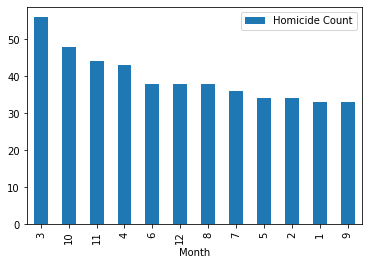

In [144]:
months_df.plot.bar(x='Month')

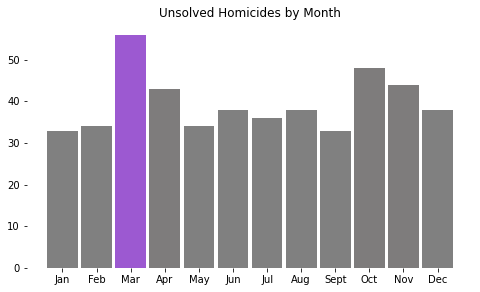

In [349]:
# bar(color) indexes from sorted data
month_colors = ['#9C59D1','#7e7c7c', '#7e7c7c', '#7e7c7c','grey','grey','grey','grey','grey','grey','grey','grey',]
fig,ax = plt.subplots(figsize=(8,4.5))
ax.bar(months_df['Month'], months_df['Homicide Count'], width=0.9, color=month_colors)
# set x labels. bar(tick_label) doesn't like strings
plt.xticks(range(1,13), mo)
ax.set_title('Unsolved Homicides by Month')
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

- [x] Sort months by count
    - [x] plot months, highlight march, lowlight rest of year
## Create file save point!

In [212]:
# case_df.to_csv('OH-Homicide-case_df.csv', sep=',')

## GIS Analysis
- [ ] Street / neighborhood data
    -'STBernard'
    -'Cincinnati,'
    -'Oxford'
    - [ ] Drop Case 850, occured in San Jose, California. lol wut?
    - [x] I think I'm gonna have to do this manually. Oh well.
    - [ ] convert addresses to gps coordinates. 

In [647]:
# case_df = pd.read_csv('OH-Homicide-case_df.csv', index_col='Unnamed: 0')

In [648]:
location_df = pd.DataFrame(case_df['Incident location'].str.split(pat='\n', expand=True))
location_df.columns = ['Incident location', 'state', 'county', 'date']
location_df

,Incident location,state,county,date
618,"3540 Reading RoadCincinnati,",Ohio,- Hamilton County,Incident date
632,"5438 Madison RoadCincinnati,",Ohio,- Hamilton County,Incident date
622,"201 Peete StreetCincinnati,",Ohio,- Hamilton County,Incident date
635,"23 Back StreetCincinnati,",Ohio,- Hamilton County,Incident date
637,"1891 Biegler StreetCincinnati,",Ohio,- Hamilton County,Incident date
...,...,...,...,...
287,"3381 Greenway AvenueCincinnati,",Ohio,- Hamilton County,Incident date
288,"3381 Greenway AvenueCincinnati,",Ohio,- Hamilton County,Incident date
289,"3381 Greenway AvenueCincinnati,",Ohio,- Hamilton County,Incident date
290,"2522 Wenning Road, Colerain TownshipCincinnati,",Ohio,- Hamilton County,Incident date


In [649]:
location_df['county'] = pd.DataFrame(location_df['county'].str.strip(to_strip='- '))
county_df.head(3)

,County
618,Hamilton County
632,Hamilton County
622,Hamilton County


In [650]:
# 39 3216 3300
location_df[location_df['county']=='Butler County']

,Incident location,state,county,date
39,Knights Inn Motel Interstate 75 and Tylersvi...,Ohio,Butler County,Incident date
3216,"In a field at 6050 Beckett RoadWest Chester,",Ohio,Butler County,Incident date
3300,"517 Wells Mill DriveOxford,",Ohio,Butler County,Incident date


In [651]:
# temporary df. probably RAM inefficient
temp_df = location_df['Incident location'].str.split(pat='Cincinnati', expand=True)
temp_df

,0,1
618,3540 Reading Road,","
632,5438 Madison Road,","
622,201 Peete Street,","
635,23 Back Street,","
637,1891 Biegler Street,","
...,...,...
287,3381 Greenway Avenue,","
288,3381 Greenway Avenue,","
289,3381 Greenway Avenue,","
290,"2522 Wenning Road, Colerain Township",","


In [652]:
location_df['city'] = 'Cincinnati'

In [653]:
location_df = location_df[['Incident location', 'city', 'county', 'state', 'date']]
location_df

,Incident location,city,county,state,date
618,"3540 Reading RoadCincinnati,",Cincinnati,Hamilton County,Ohio,Incident date
632,"5438 Madison RoadCincinnati,",Cincinnati,Hamilton County,Ohio,Incident date
622,"201 Peete StreetCincinnati,",Cincinnati,Hamilton County,Ohio,Incident date
635,"23 Back StreetCincinnati,",Cincinnati,Hamilton County,Ohio,Incident date
637,"1891 Biegler StreetCincinnati,",Cincinnati,Hamilton County,Ohio,Incident date
...,...,...,...,...,...
287,"3381 Greenway AvenueCincinnati,",Cincinnati,Hamilton County,Ohio,Incident date
288,"3381 Greenway AvenueCincinnati,",Cincinnati,Hamilton County,Ohio,Incident date
289,"3381 Greenway AvenueCincinnati,",Cincinnati,Hamilton County,Ohio,Incident date
290,"2522 Wenning Road, Colerain TownshipCincinnati,",Cincinnati,Hamilton County,Ohio,Incident date


In [654]:
location_df['Incident location'] = temp_df[0]
location_df.head(3)

,Incident location,city,county,state,date
618,3540 Reading Road,Cincinnati,Hamilton County,Ohio,Incident date
632,5438 Madison Road,Cincinnati,Hamilton County,Ohio,Incident date
622,201 Peete Street,Cincinnati,Hamilton County,Ohio,Incident date


- [ ] Manually fix non-Cinci entries found by skimming data
    - Case #s 39, 3216, 3300, 290, 3148, 1252, 66
    - [x] adjust addresses
    - [ ] ensure correct cities have been linked

In [655]:
location_df.loc[[39, 3216, 3300, 290, 3148, 1252, 66]]

,Incident location,city,county,state,date
39,Knights Inn Motel Interstate 75 and Tylersvi...,Cincinnati,Butler County,Ohio,Incident date
3216,"In a field at 6050 Beckett RoadWest Chester,",Cincinnati,Butler County,Ohio,Incident date
3300,"517 Wells Mill DriveOxford,",Cincinnati,Butler County,Ohio,Incident date
290,"2522 Wenning Road, Colerain Township",Cincinnati,Hamilton County,Ohio,Incident date
3148,"S/B I-75 at 7.0 MPSt Bernard,",Cincinnati,Hamilton County,Ohio,Incident date
1252,"In the area of 3300 Queen Anne PlaceGrove City,",Cincinnati,Franklin County,Ohio,Incident date
66,Little Miami River/ E. Kemper Road-Riverside ...,Cincinnati,Hamilton County,Ohio,Incident date


In [656]:
case_citis = {39: 'West Chester', 3216: 'West Chester', 3300: 'Oxford', 290: 'Colerain Township',
                3148: 'St. Bernard' , 1252: ' Grove City', 66: 'Loveland'}
case_cities_df = pd.DataFrame({'city': case_cities}, index=case_cities.keys())

In [657]:
# print out list so I can manually edit the text into a dict
temp_list = list(location_df['Incident location'].loc[[39, 3216, 3300, 290, 3148, 1252, 66]])
temp_list

[' Knights Inn Motel  Interstate 75 and Tylersville RdUnion Township (now known as West Chester), ',
 ' In a field at 6050 Beckett RoadWest Chester, ',
 ' 517 Wells Mill DriveOxford, ',
 ' 2522 Wenning Road, Colerain Township',
 ' S/B I-75 at 7.0 MPSt Bernard, ',
 ' In the area of 3300 Queen Anne PlaceGrove City, ',
 ' Little Miami River/ E. Kemper Road-Riverside DriveLoveland, ']

In [658]:
# manually clean up the location information
temp_loc = {' Knights Inn Motel  Interstate 75 and Tylersville RdUnion Township (now known as West Chester), ':
            'I-75 and Tylersville Rd',
            ' In a field at 6050 Beckett RoadWest Chester, ':
            '6050 Beckett Road',
            ' 517 Wells Mill DriveOxford, ':
            '517 Wells Mill Drive',
            ' 2522 Wenning Road, Colerain Township':
            '2522 Wenning Road',
            ' S/B I-75 at 7.0 MPSt Bernard, ':
            'S/B I-75 at 7.0 MP',
            ' In the area of 3300 Queen Anne PlaceGrove City, ':
            '3300 Queen Anne Place',
            ' Little Miami River/ E. Kemper Road-Riverside DriveLoveland':
            'Little Miami River/ E. Kemper Road'}

In [659]:
location_df.loc[case_cities.keys()]

,Incident location,city,county,state,date
39,Knights Inn Motel Interstate 75 and Tylersvi...,Cincinnati,Butler County,Ohio,Incident date
3216,"In a field at 6050 Beckett RoadWest Chester,",Cincinnati,Butler County,Ohio,Incident date
3300,"517 Wells Mill DriveOxford,",Cincinnati,Butler County,Ohio,Incident date
290,"2522 Wenning Road, Colerain Township",Cincinnati,Hamilton County,Ohio,Incident date
3148,"S/B I-75 at 7.0 MPSt Bernard,",Cincinnati,Hamilton County,Ohio,Incident date
1252,"In the area of 3300 Queen Anne PlaceGrove City,",Cincinnati,Franklin County,Ohio,Incident date
66,Little Miami River/ E. Kemper Road-Riverside ...,Cincinnati,Hamilton County,Ohio,Incident date


In [660]:
location_df.replace({'Incident location': temp_loc}, inplace=True)

In [661]:
location_df.loc[case_cities.keys()]

,Incident location,city,county,state,date
39,I-75 and Tylersville Rd,Cincinnati,Butler County,Ohio,Incident date
3216,6050 Beckett Road,Cincinnati,Butler County,Ohio,Incident date
3300,517 Wells Mill Drive,Cincinnati,Butler County,Ohio,Incident date
290,2522 Wenning Road,Cincinnati,Hamilton County,Ohio,Incident date
3148,S/B I-75 at 7.0 MP,Cincinnati,Hamilton County,Ohio,Incident date
1252,3300 Queen Anne Place,Cincinnati,Franklin County,Ohio,Incident date
66,Little Miami River/ E. Kemper Road-Riverside ...,Cincinnati,Hamilton County,Ohio,Incident date


In [662]:
case_cities_df

,city
39,West Chester
3216,West Chester
3300,Oxford
290,Colerain Township
3148,St. Bernard
1252,Grove City
66,Loveland


In [663]:
#l = pd.DataFrame(location_df.copy())
location_df['city'].update(case_cities_df['city'])
location_df.loc[66]

Incident location     Little Miami River/ E. Kemper Road-Riverside ...
city                                                          Loveland
county                                                 Hamilton County
state                                                             Ohio
date                                                     Incident date
Name: 66, dtype: object

In [469]:
# location_df['Incident location'].to_csv('Incident location.csv')

In [664]:
incident_gps = pd.read_csv('Incident-location-gps.csv', sep=',', index_col='case')
incident_gps.head(3)

,Incident location,latitude,longitude
case,,,
618,3540 Reading Road,39.145773,-84.489590
632,5438 Madison Road,39.161592,-84.399650
622,201 Peete Street,39.115538,-84.513352


In [665]:
location_df

,Incident location,city,county,state,date
618,3540 Reading Road,Cincinnati,Hamilton County,Ohio,Incident date
632,5438 Madison Road,Cincinnati,Hamilton County,Ohio,Incident date
622,201 Peete Street,Cincinnati,Hamilton County,Ohio,Incident date
635,23 Back Street,Cincinnati,Hamilton County,Ohio,Incident date
637,1891 Biegler Street,Cincinnati,Hamilton County,Ohio,Incident date
...,...,...,...,...,...
287,3381 Greenway Avenue,Cincinnati,Hamilton County,Ohio,Incident date
288,3381 Greenway Avenue,Cincinnati,Hamilton County,Ohio,Incident date
289,3381 Greenway Avenue,Cincinnati,Hamilton County,Ohio,Incident date
290,2522 Wenning Road,Colerain Township,Hamilton County,Ohio,Incident date


In [666]:
incident_gps.columns.difference(location_df.columns)

Index(['latitude', 'longitude'], dtype='object')

In [667]:
#l_df = location_df.copy()
# find the index.difference between incident gps and locations to only add  new data columns
cols = list(incident_gps.columns.difference(location_df.columns))
pd.concat([location_df, incident_gps[cols]], axis=1) 

,Incident location,city,county,state,date,latitude,longitude
618,3540 Reading Road,Cincinnati,Hamilton County,Ohio,Incident date,39.145773,-84.489590
632,5438 Madison Road,Cincinnati,Hamilton County,Ohio,Incident date,39.161592,-84.399650
622,201 Peete Street,Cincinnati,Hamilton County,Ohio,Incident date,39.115538,-84.513352
635,23 Back Street,Cincinnati,Hamilton County,Ohio,Incident date,39.114979,-84.515423
637,1891 Biegler Street,Cincinnati,Hamilton County,Ohio,Incident date,39.128551,-84.562347
...,...,...,...,...,...,...,...
287,3381 Greenway Avenue,Cincinnati,Hamilton County,Ohio,Incident date,39.148813,-84.630633
288,3381 Greenway Avenue,Cincinnati,Hamilton County,Ohio,Incident date,39.148813,-84.630633
289,3381 Greenway Avenue,Cincinnati,Hamilton County,Ohio,Incident date,39.148813,-84.630633
290,2522 Wenning Road,Colerain Township,Hamilton County,Ohio,Incident date,39.248750,-84.570081


In [668]:
case_df.update(location_df['Incident location'], overwrite=True)
case_df.head(3)

,Case number,Incident location,Incident date,Homicide date,Gender,Race/Ethnicity,Law enforcement agency,details,Age,Hair color,Eye color,Nickname or alias,Date of birth,Height,Weight,age_bin
618,618,3540 Reading Road,2011-01-02,1/2/2011,Male,Black,Cincinnati Police Department,Twenty two year old Rafeal Ross was shot at 3...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,"(20, 30]"
632,632,5438 Madison Road,2011-05-26,5/26/2011,Male,Black,Cincinnati Police Department,Nineteen year old David Gould was shot at 438...,19.0,NaN,NaN,NaN,NaN,NaN,NaN,"(10, 20]"
622,622,201 Peete Street,2011-03-01,3/1/2011,Male,Black,Cincinnati Police Department,Twenty five year old Patrick Massey was shot ...,25.0,NaN,NaN,NaN,NaN,NaN,NaN,"(20, 30]"


In [669]:
incident_gps.head()

,Incident location,latitude,longitude
case,,,
618,3540 Reading Road,39.145773,-84.489590
632,5438 Madison Road,39.161592,-84.399650
622,201 Peete Street,39.115538,-84.513352
635,23 Back Street,39.114979,-84.515423
637,1891 Biegler Street,39.128551,-84.562347


In [670]:
cols2 = list(incident_gps.columns.difference(case_df.columns))
case_df = pd.concat([case_df, incident_gps[cols2]], axis=1)
case_df =pd.concat([case_df, location_df[['city', 'state']]], axis=1)
case_df.head(3)

,Case number,Incident location,Incident date,Homicide date,Gender,Race/Ethnicity,Law enforcement agency,details,Age,Hair color,Eye color,Nickname or alias,Date of birth,Height,Weight,age_bin,latitude,longitude,city,state
618,618,3540 Reading Road,2011-01-02,1/2/2011,Male,Black,Cincinnati Police Department,Twenty two year old Rafeal Ross was shot at 3...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,"(20, 30]",39.145773,-84.489590,Cincinnati,Ohio
632,632,5438 Madison Road,2011-05-26,5/26/2011,Male,Black,Cincinnati Police Department,Nineteen year old David Gould was shot at 438...,19.0,NaN,NaN,NaN,NaN,NaN,NaN,"(10, 20]",39.161592,-84.399650,Cincinnati,Ohio
622,622,201 Peete Street,2011-03-01,3/1/2011,Male,Black,Cincinnati Police Department,Twenty five year old Patrick Massey was shot ...,25.0,NaN,NaN,NaN,NaN,NaN,NaN,"(20, 30]",39.115538,-84.513352,Cincinnati,Ohio


In [671]:
case_df.to_csv('cleaned-case-data.csv', sep=',')

In [679]:
case_map_df = case_df.dropna(subset=['latitude', 'longitude'])

In [680]:
case_map_df[case_map_df['latitude'].isna()==True]

,Case number,Incident location,Incident date,Homicide date,Gender,Race/Ethnicity,Law enforcement agency,details,Age,Hair color,Eye color,Nickname or alias,Date of birth,Height,Weight,age_bin,latitude,longitude,city,state


In [674]:
bounds = [[39.00164834007386, -84.83564412386342], # SW corner to NE corner
          [39.34943767762469, -84.24323404504084]]
m = folium.Map(location=[39.103119,-84.512016], zoom_start=11)
#m.fit_bounds(bounds[0], bounds[1])
# m

In [602]:
six = [case_df.loc[618]['latitude'], case_df.loc[618]['longitude']]
[type(x) for x in six]

[numpy.float64, numpy.float64]

In [677]:
def add_marker(df, map_obj):
    ''' expects a dataframe that at least has ['name', 'latitude', 'longitude'] and
    a map object to place them. returns a map with markers'''
    cases = list(df.index)
    for case in cases :
        folium.Marker(
            location=[df.loc[case]['latitude'], df.loc[case]['longitude']],
            popup=df.loc[case]['details'],).add_to(map_obj)
    return map_obj

In [584]:
cases = list(case_map_df.index)
for case in cases:
    folium.Marker(
        location=[case_map_df.loc[case]['latitude'], case_map_df.loc[case]['longitude']],
        popup=case_map_df.loc[case]['details']
    ).add_to(m)

In [675]:
# 39.145773 	-84.489590
folium.Marker(
        location=[39.145773, -84.489590],
        popup='618'
    ).add_to(m)
folium.Marker(
        location=[39.115538, -84.513352],
        popup='622'
    ).add_to(m)

In [682]:
add_marker(case_map_df, m)

In [ ]:
fix cases
842
803
1049
3123
3116
788
1015
1121
715
1116
1119
1252
1075